In [1]:
# Importation des modules

import pandas as pd
from gensim.models import Word2Vec
import random
import matplotlib.pyplot as plt
import numpy as np

#Affichage de toutes les colonnes

pd.set_option('display.max_columns', 500)

In [2]:
w2v_model_novice = Word2Vec.load("results/word2vec_novice_300.model")

w2v_model_exp = Word2Vec.load("results/word2vec_exp_300.model")

In [13]:
words_novice = list(w2v_model_novice.wv.vocab.keys())
words_exp = list(w2v_model_exp.wv.vocab.keys())

In [27]:
def overlap(model1, model2, n , word):

    neighborhood_1 = set([i[0] for i in model1.wv.most_similar(positive=[word], topn = n)])
    neighborhood_2 = set([i[0] for i in model2.wv.most_similar(positive=[word], topn = n)])

    return len(neighborhood_1.intersection(neighborhood_2))

In [22]:
words_common = list(set(words_exp).intersection(set(words_novice)))
random.shuffle(words_common)

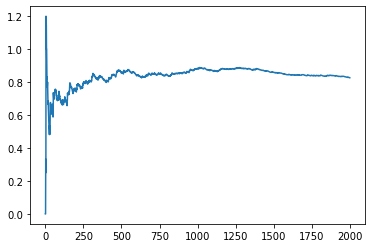

In [23]:
L_10 = [overlap(w2v_model_novice, w2v_model_exp, 10, word) for word in words_common[:2000]]
plt.plot([np.mean(L_10[:i]) for i in range(2000)])

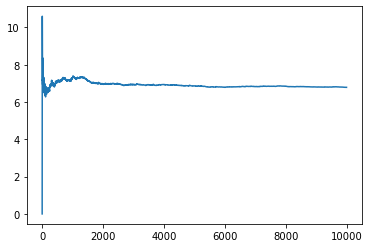

In [28]:
L_100 = [overlap(w2v_model_novice, w2v_model_exp, 100, word) for word in words_common[:10000]]
plt.plot([np.mean(L_100[:i]) for i in range(10000)])

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


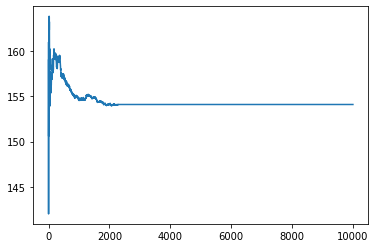

In [56]:
L_1000 = [overlap(w2v_model_novice, w2v_model_exp, 1000, word) for word in words_common[:10000]]
plt.plot([np.mean(L_1000[:i]) for i in range(10000)])

In [53]:
def rank(model, i, j):
    
    k = -1
    K = 10
    
    while k == -1 and 10 * K < len(words_exp):
        neighborhood = [i[0] for i in model.wv.most_similar(positive=[i], topn = K)]
        try:
            k = neighborhood.index(j)
        except:
            k = -1
        K *= 10
            
    return k + 1

def spread(model1, model2, n, word):

    neighborhood_1 = [i[0] for i in model1.wv.most_similar(positive=[word], topn = n)]
    ranks = [rank(model2, word, j) for j in neighborhood_1]
    return max(ranks)

In [54]:
#print(w2v_model_exp.wv.most_similar(positive=['droite'], topn = 10))
#rank(w2v_model_exp, 'droite', 'sarkozysme')

In [55]:
spread(w2v_model_novice, w2v_model_exp, 10, 'droite')

831

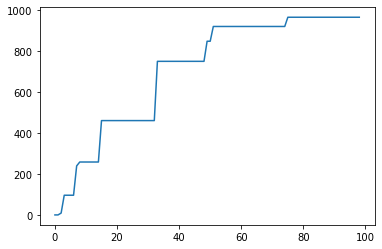

In [59]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, i, 'demain') for i in range(1,100)])

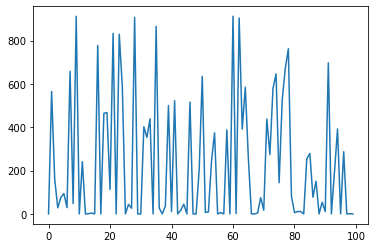

In [60]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, 6, word) for word in words_common[:100]])